# Приоритизация гипотез и анализ результатов A/B-теста

# Описание проекта

В крупном интернет-магазине подготовлен список гипотез для увеличения выручки. Необходимо провести приоритизацию гипотез с применением фреймворков ICE, RICE и  проанализировать результаты A/B-теста с проведением проверок статистических гипотез.

# Цель проекта

Выбрать наиболее приоритетные гипотезы и провести оценку результатов A/B-теста  

# Описание данных

*Датасет hypothesis.csv* (гипотезы по увеличению выручки с параметрами для приоритизации)  

**Hypothesis** — краткое описание 9-ти гипотез  
**Reach** — охват пользователей по 10-балльной шкале  
**Impact** — влияние на пользователей по 10-балльной шкале  
**Confidence** — уверенность в гипотезе по 10-балльной шкале  
**Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале     

*Датасет orders.csv* (информация о заказах)  

**transactionId** — идентификатор заказа    
**visitorId** — идентификатор пользователя, совершившего заказ  
**date** — дата, когда был совершён заказ  
**revenue** — выручка заказа  
**group** — группа A/B-теста, в которую попал заказ  

*Датасет visitors.csv* (информация о пользователях) 

**date** — дата  
**group** — группа A/B-теста  
**visitors** — количество пользователей в указанную дату в указанной группе A/B-теста  

# Содержание  

**1 Загрузка и предобработка данных**  
1.1 Импорт библиотек и загрузка данных  
1.2 Обзор и предобработка данных  
1.3 Вывод  
**2 Приоритизация гипотез**  
2.1 Фреймворк ICE  
2.2 Фреймворк RICE  
2.3 Вывод  
**3 Анализ A/B-теста**  
3.1 Агрегация кумулятивных данных по дням  
3.2 График кумулятивной выручки по группам  
3.3 График кумулятивного среднего чека по группам  
3.4 График относительного изменения кумулятивного среднего чека группы B к группе A  
3.5 График кумулятивного среднего количества заказов по группам  
3.6 График относительного изменения кумулятивного среднего количества заказов группы B к группе A  
3.7 Точечный график количества заказов по пользователям  
3.8 Расчет 95-го и 99-го перцентилей количества заказов на пользователя и выбор границы для определения аномальных пользователей  
3.9 Точечный график стоимостей заказов  
3.10 Расчет 95-го и 99-го перцентилей стоимости заказов и выбор границы для определения аномальных заказов  
3.11 Расчет статистической значимости различий в среднем количестве заказов между группами по «сырым» данным  
3.12 Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным  
3.13 Расчет статистической значимости различий в среднем количестве заказов между группами по «очищенным» данным  
3.14 Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным  
3.15 Решение по результатам теста  
**4 Общий вывод**  

## 1. Загрузка и предобработка данных

### 1.1 Импорт библиотек и загрузка данных

Импортируем библиотеки:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

Загружаем данные и сохраняем их в соответствующих переменных:

In [21]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### 1.2 Обзор и предобработка данных

Начнем с обзора данных таблицы **hypothesis**. Снимем ограничение на ширину столбцов для полного просмотра описания гипотез, выведем на экран данные и общую информацию:

In [22]:
pd.set_option('display.max_colwidth', None)
display(hypothesis)
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Данные в порядке, есть описание гипотез и числовые параметры. Пропусков и дубликатов нет, но есть нарушения стиля при именовании столбцов (используются буквы верхнего регистра). Проведем предобработку и проверим результат:

In [23]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Теперь проверим таблицу **orders**, выведем первые 5 строк, общую информацию и период, за который собраны данные:

In [24]:
display(orders.head())
orders.info()
print()
print('Минимальная дата:', orders['date'].min())
print('Максимальная дата:', orders['date'].max())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

Минимальная дата: 2019-08-01
Максимальная дата: 2019-08-31


Продолжительность теста - 30 дней, пропусков в данных нет, но при этом также отмечается нарушение стиля - в наименованиях столбцов используются буквы верхнего регистра и не используется символ нижнего подчеркивания для разделения слов. Кроме того, дата представлена типом `object`. Внесем необходимые правки и проверим результат:

In [25]:
orders.columns = [x.replace('Id', '_id') for x in orders.columns]  # меняем написание "id"
print(orders.columns)  # контролируем результат

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')


In [26]:
orders['date'] = pd.to_datetime(orders['date']) # меняем тип данных на datetime64
orders.info()  # контролируем результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Проведем аналогичный обзор таблицы **visitors**:

In [27]:
display(visitors.head())
visitors.info()
print()
print('Минимальная дата:', visitors['date'].min())
print('Максимальная дата:', visitors['date'].max())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

Минимальная дата: 2019-08-01
Максимальная дата: 2019-08-31


Период данных с посещениями пользователей идентичен таблице с заказами, пропущенных значений нет, правила стиля соблюдены, но необходимо исправить тип данных в столбце с датой. Проведем необходимую обработку и проверим результат:

In [28]:
visitors['date'] = pd.to_datetime(visitors['date']) # меняем тип данных на datetime64
visitors.info()  # контролируем результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Согласно описания данных, в таблицах **orders** и **visitors** указана принадлежность пользователей к контрольной группе (А) или эксперементальной группе (B). Проверим, есть ли пользователи, которые могли попасть в обе группы:

In [29]:
orders.groupby('visitor_id').agg({'group' : 'nunique'}).query('group>1').count()

group    58
dtype: int64

Действительно, есть 58 таких пользователей. Создадим список с идентификаторами пользователей попавших в обе группы, сгруппировав  данные таблицы **orders** по **visitor_id**, и сделав срез данных, где на каждого пользователя приходится более 1 группы:

In [30]:
double_users = orders.groupby('visitor_id').agg({'group' : 'nunique'}).reset_index().query('group>1')['visitor_id'].unique()
double_users

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830], dtype=int64)

Теперь проверим, всегда ли эти пользователи попадают в обе группы. Для этого сделаем срез таблицы **orders**, оставив там с помощью метода `query()` только пользователей из списка выше. Затем сгруппируем полученные данные по дате, группе и уникальному номеру пользователей: 

In [32]:
orders.query('visitor_id in @double_users').groupby(['date', 'group', 'visitor_id']).agg({'visitor_id' : 'count'})

visitor_id
date       group visitor_id            
2019-08-01 A     4256040402           1
           B     8300375              1
                 2716752286           1
                 3062433592           2
2019-08-02 A     2716752286           1
...                                 ...
2019-08-31 A     2600415354           1
                 4256040402           1
           B     232979603            1
                 4120364173           1
                 4256040402           1

[170 rows x 1 columns]

Из таблицы видно, что так происходит не всегда, из чего можно предположить, что пользователи попадали в разные группы, используя разные типы устройств. В любом случае, эксперимент с такими пользователями не может быть чистым, поскольку они видели разные версии страниц и непонятно, какая из версий сильнее повлияла на решение оформить заказ. Поэтому удалим данные этих пользователей из таблиц **orders** и **visitors**.

Для этого создадим сначала список с количеством посещений из таблицы **orders**, сгруппированный по датам и группам:

In [33]:
wrong_list = orders.query('visitor_id in @double_users').groupby(['date', 'group']).agg({'visitor_id' : 'count'})
wrong_list.columns = ['wrong_visitors']  # назначаем название колонки с кол-вом посещений
wrong_list.head()  # контролируем результат

wrong_visitors
date       group                
2019-08-01 A                   1
           B                   4
2019-08-02 A                   1
           B                   1
2019-08-03 B                   2

Теперь вычтем посещения удаляемых пользователей из таблицы **visitors**:

In [34]:
visitors = visitors.merge(wrong_list, left_on=['date', 'group'], right_on=['date', 'group'], how='left')  # присоединяем колонку для расчета
visitors['wrong_visitors'] = visitors['wrong_visitors'].fillna(0).astype(int)  # убираем пропуски и приводим к целочисленным значениям
visitors['visitors'] = visitors['visitors'] - visitors['wrong_visitors']  # вычитаем посещения
visitors = visitors.drop(columns =['wrong_visitors']) # удаляем вспомогательную колонку
visitors  # контролируем результат

,date,group,visitors
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-03,A,507
3,2019-08-04,A,712
4,2019-08-05,A,753
...,...,...,...
57,2019-08-27,B,715
58,2019-08-28,B,648
59,2019-08-29,B,526
60,2019-08-30,B,487


И удаляем данные пользователей из таблицы заказов:

In [18]:
print('Количество уникальных пользователей до удаления:', orders['visitor_id'].nunique())
orders = orders.query('visitor_id not in @double_users')
print('Количество уникальных пользователей после удаления:', orders['visitor_id'].nunique())

Количество уникальных пользователей до удаления: 1031
Количество уникальных пользователей после удаления: 973


Теперь данные по пользователям скорректированы, и в завершение предобработки данных, проверим таблицы **orders** и **visitors** на наличие дубликатов:

In [35]:
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0


Дубликатов нет.

### 1.3 Вывод

На этапе обзора данных обнаружено следующее:
- Во всех трех датасетах отсутствуют пропуски и дубликаты, в то же время выявлены нарушения стиля при именовании заголовков, а также несоответствие формата данных в столбцах с датой и временем.  
- Установлена продолжительность проведения A/B теста - 30 дней, c 01.08.2019г. по 31.08.2019г.  
- Найдены 58 пользователей, попавших во время тестирования в обе группы (принято решение об удалении данных этих пользователей).  

Необходимая предобработка проведена, данные готовы для дальнейшей работы над проектом.

## 2 Приоритизация гипотез

### 2.1 Фреймворк ICE

Проведем приоритизацию гипотез согласно формуле: $$ICE = \frac {Impact * Confidence}{Efforts}$$  
Сохраним результат расчета в столбец **ice_score** и выведем результат, отсортированный по убыванию (5 приоритетных гипотез):

In [36]:
hypothesis['ice_score'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
display(hypothesis[['hypothesis', 'ice_score']].sort_values(by='ice_score', ascending=False).head())

,hypothesis,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00


Согласно расчетам с использованием данного метода, можно выделить три наиболее приоритетные гипотезы: 
1. Запустить акцию, дающую скидку на товар в день рождения (ice_score 16.20)
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (ice_score 13.33)	
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (ice_score 11.20)

### 2.2 Фреймворк RICE

Проведем приоритизацию гипотез согласно формуле: $$RICE = \frac {Reach * Impact * Confidence}{Efforts}$$  
Сохраним результат расчета в столбец **rice_score** и выведем результат, отсортированный по убыванию (5 приоритетных гипотез):

In [37]:
hypothesis['rice_score'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
display(hypothesis[['hypothesis', 'rice_score']].sort_values(by='rice_score', ascending=False).head())

,hypothesis,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2


Согласно расчетам с использованием метода RICE, в список список наиболее приоритетных гипотез вошли те же 5 гипотез, но список лидеров выглядит немного иначе:  
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (ice_score 112)
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (rice_score 56)
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (rice_score 40)

### 2.3 Вывод

Гипотеза с индексом 7: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",  является наиболее приоритетной.  

Изменение приоритизации произошло из-за отличия методов расчетов: при применении **RICE** у нас добавился еще один параметр **reach** -   охват аудитории. У гипотезы с индексом 7, его значение оказалось максмальным - 10, т.е. влияние на пользователей по охвату будет максимальным, в то время как у гипотезы  индексом 8 охват оценен всего в 1 балл, а у гипотезы с индексом 0 - в 3 балла. Таким образом, увеличение множителя в числителе повлияло на увеличение расчетного результата и вывело гипотезу с индексом 7 на первое место.

## 3 Анализ A/B-теста

### 3.1 Агрегация кумулятивных данных по дням

Для анализа проведенного A/B теста нам нужны агрегированные кумулятивные данные по дням. Начнем с создания массива уникальных пар значений дат и групп:

In [38]:
datesGroups = orders[['date','group']].drop_duplicates()

Следующим шагом получим агрегированные кумулятивные по дням данные о заказах:

In [39]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg(
        {
            'date' : 'max',
            'group' : 'max',
            'transaction_id' : 'nunique',
            'visitor_id' : 'nunique',
            'revenue' : 'sum'
        }
    ),
    axis=1
).sort_values(by=['date','group'])

ordersAggregated.head(4)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748


Аналогичным образом получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина: 

In [40]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg(
        {
            'date' : 'max',
            'group' : 'max',
            'visitors' : 'sum'
        }
    ),
    axis=1
).sort_values(by=['date','group'])

visitorsAggregated.head(4)

,date,group,visitors
55,2019-08-01,A,718
66,2019-08-01,B,709
175,2019-08-02,A,1336
173,2019-08-02,B,1289


Теперь объединим кумулятивные данные методом merge() в одну таблицу **cumulativeData** и присвоим ее столбцам понятные названия:

In [41]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(4)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,718
1,2019-08-01,B,21,20,101217,709
2,2019-08-02,A,44,38,242401,1336
3,2019-08-02,B,45,43,266748,1289


Агрегированные кумулятивные данные по дням получены, можно переходить к построению графиков.

### 3.2 График кумулятивной выручки по группам

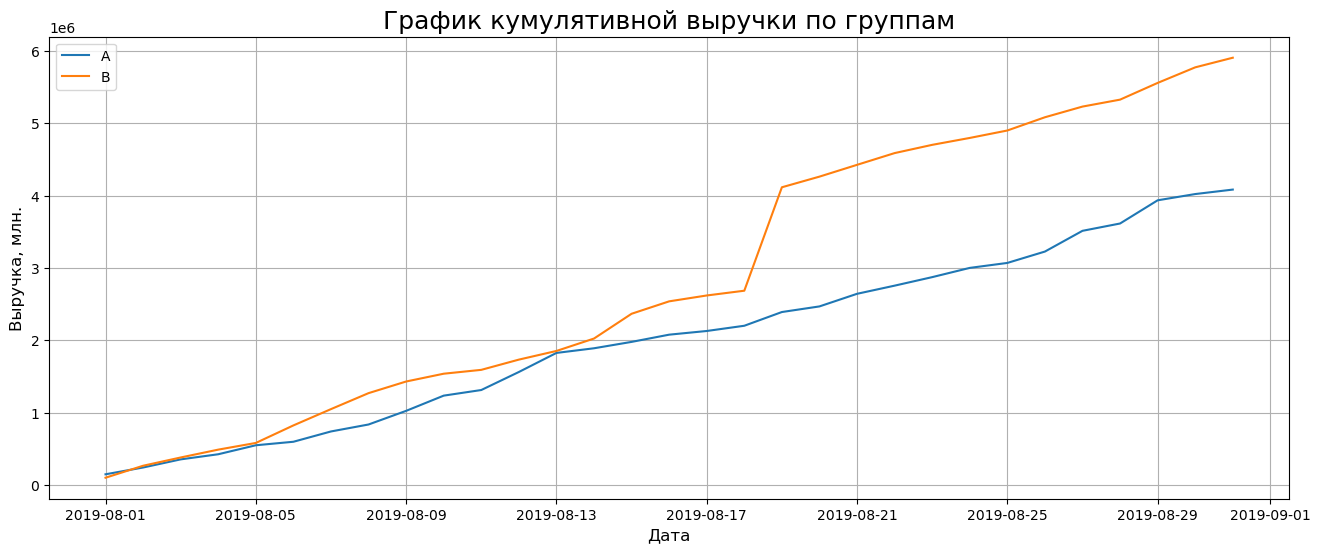

In [43]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# задаем размер сетки для графиков
plt.figure(figsize=(16,6))

# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

# настраиваем подписи и дополнительные параметры графика
plt.title('График кумулятивной выручки по группам', size=18)
plt.xlabel('Дата', size=12)
plt.ylabel('Выручка, млн.', size=12)
plt.legend()
plt.grid()
plt.show()

В группе **А** мы наблюдаем линейный рост выручки.  
В группе **B** также наблюдается линейный рост, но с 18 по 19 августа 2019г. отмечается резкий прирост выручки. Это может быть связано с увеличением количества заказов или с увеличением среднего чека покупателей за счет более крупных заказов.

### 3.3 График кумулятивного среднего чека по группам

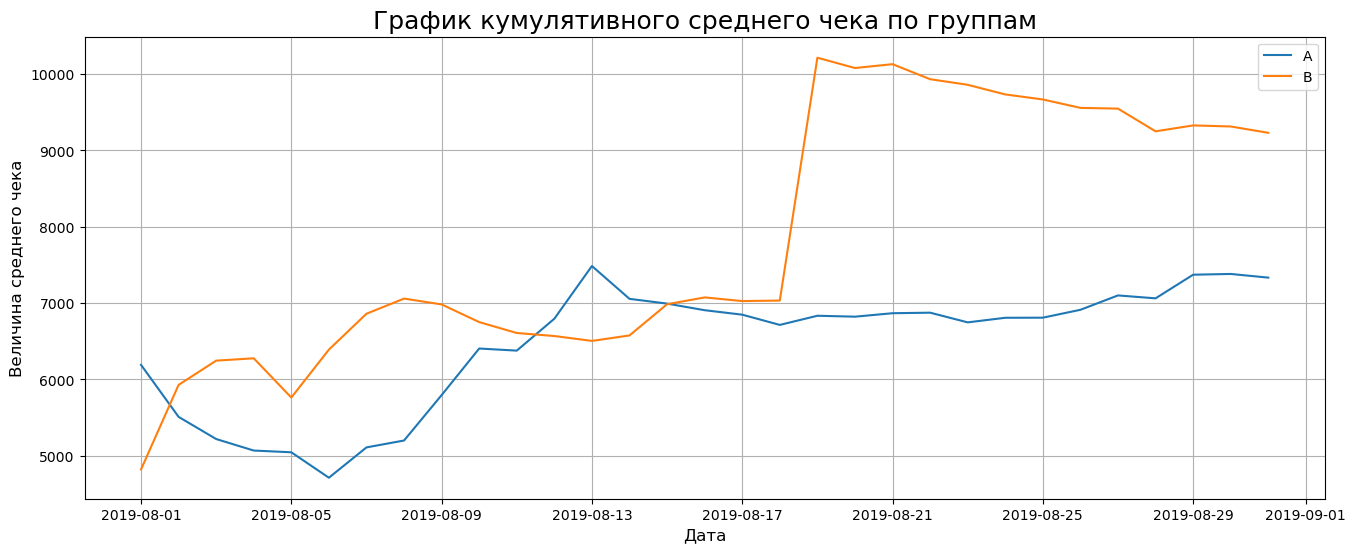

In [44]:
# задаем размер сетки для графиков
plt.figure(figsize=(16,6))

# строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

# строим график среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

# настраиваем подписи и дополнительные параметры графика
plt.title('График кумулятивного среднего чека по группам', size=18)
plt.xlabel('Дата', size=12)
plt.ylabel('Величина среднего чека', size=12)
plt.legend()
plt.grid()
plt.show()

В группе **А** до 06 августа отмечается снижение среднего чека с ~ 6,2 тыс. до ~ 4,5 тыс., затем рост до 13 августа и стабилизация на значении около 7 тыс.(+-0,2).  
В группе **В** с 01 до 02 августа отмечается резкий рост с 3,5 до 5,5 тыс., затем волнообразный прирост до ~ 6,7 тыс. 18 августа, и далее резкий скачок с 18 до 19 августа до 10,5 тыс., за которым следует плавное снижение до ~ 9,2 тыс., что подтверждает версию с увеличением размера заказов 18-19 августа. В этом случае, для того чтобы мы могли увидеть стабилизацию среднего чека в группе **B** нам необходим более широкий горизонт событий.  
В целом, если не брать во внимание выброс группы **В** от 18 августа, после двух недель теста графики ведут себя стабильно.

### 3.4 График относительного изменения кумулятивного среднего чека группы B к группе A

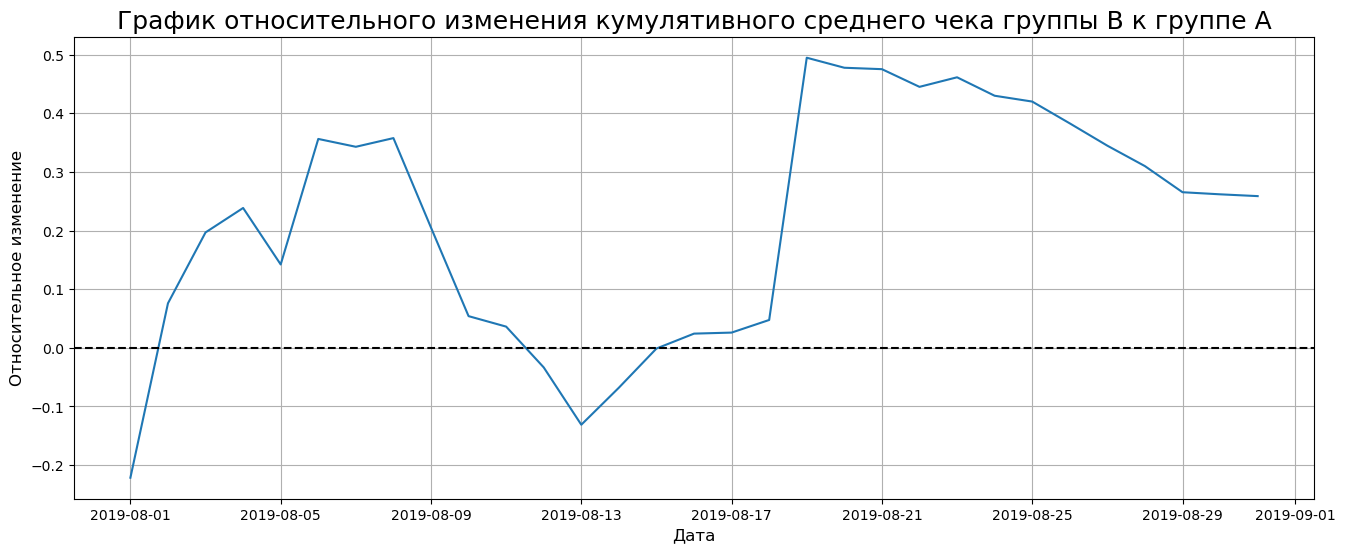

In [45]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# задаем размер сетки для графика
plt.figure(figsize=(16,6))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB'])
         / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

# настраиваем подписи и дополнительные параметры графика
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size=18)
plt.xlabel('Дата', size=12)
plt.ylabel('Относительное изменение', size=12)
plt.grid()
plt.show()

Показатели группы **B** относительно нулевой отметки (показатели группы **А**) в нескольких точках имеют резкие разнонаправленные движения, это подтверждает наличие крупных заказов и выбросов.

### 3.5 График кумулятивного среднего количества заказов по группам

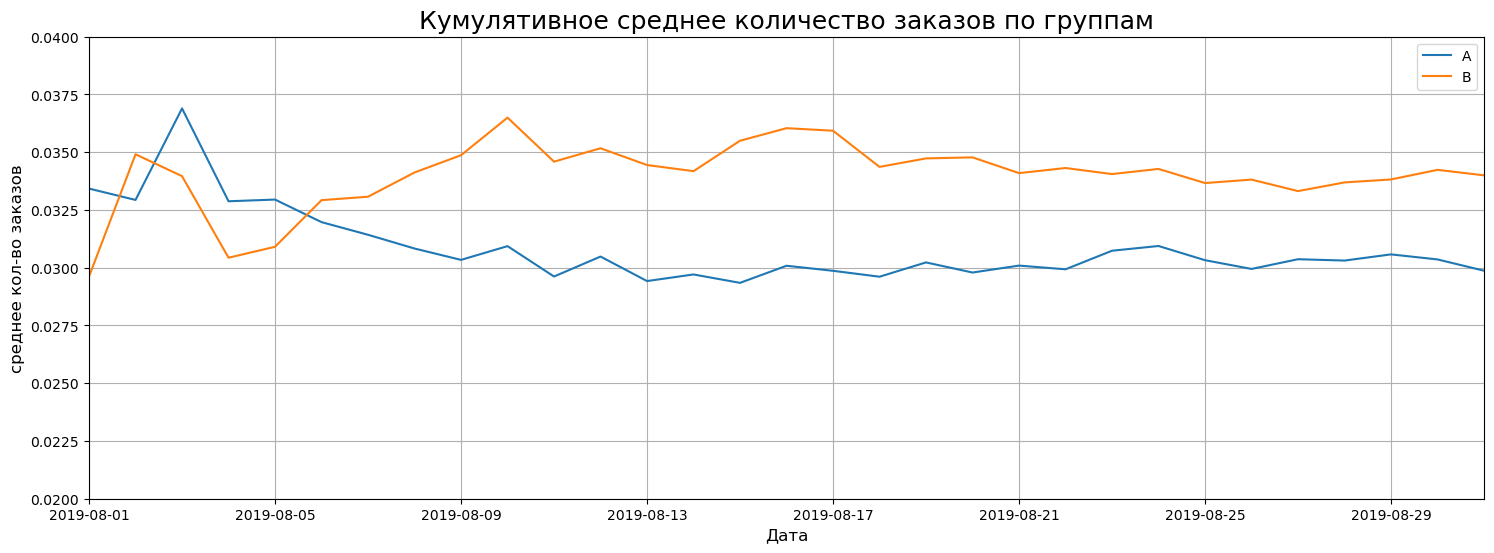

In [46]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# задаем размер сетки для графиков
plt.figure(figsize=(18,6))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.02, 0.04])

# настраиваем подписи и дополнительные параметры графика
plt.title('Кумулятивное среднее количество заказов по группам', size=18)
plt.xlabel('Дата', size=12)
plt.ylabel('среднее кол-во заказов', size=12)
plt.legend()
plt.grid()
plt.show()

В группе **А** до 5 августа кумулятивное среднее кол-во заказов выглядит лучше, 3 августа выходит на пик (~ 3,6), затем снижение, и после 6 августа уже уступает группе **В**, продолжая плавно снижаться, а примерно после 13 августа уже стабилизируется на уровне ~ 2,6.  
Кумулятивное среднее группы **B** вначале своего пути имеет схожие колебания, с пиком 2 августа (на уровне ~ 3,1), затем также следует снижение, но после 4 августа начинается рост, и после 6 августа группа выходит в лидеры и стабилизируется на уровне ~ 2,9 (+-0,1). В итоге, кумулятивное среднее количество заказов группы **В** выглядит лучше. 

### 3.6 График относительного изменения кумулятивного среднего количества заказов группы B к группе A

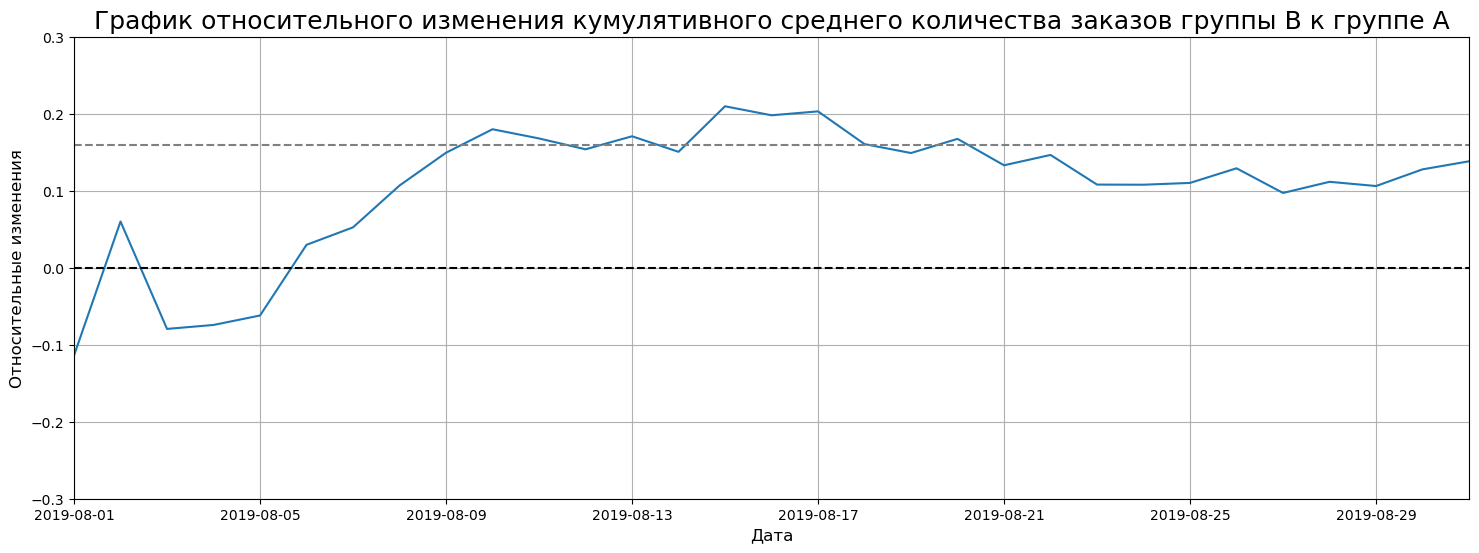

In [47]:
# собираем данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# задаем размер сетки для графика
plt.figure(figsize=(18,6))

# cтроим отношение конверсий
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1)

# добавляем оси X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='grey', linestyle='--')

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.3, 0.3])

# настраиваем подписи и дополнительные параметры графика
plt.title('График относительного изменения кумулятивного среднего количества заказов группы B к группе A', size=18)
plt.xlabel('Дата', size=12)
plt.ylabel('Относительные изменения', size=12)

plt.grid()
plt.show()

Относительный прирост кумулятивного среднего количества заказов группы **B** достиг к 15 августа отметки ~21%, а после 17 августа отмечается плавная корректировка до уровня 16%, и можно предположить, что показатель останется на этом уровне, но, прежде чем делать вывод, стоит проверить данные на аномалии.

### 3.7 Точечный график количества заказов по пользователям

Сначала подсчитаем количество заказов по пользователям, сгруппировав таблицу с заказами по **visitor_id**, назовем столбцы понятными именами и отсортируем по убыванию количества заказов, чтобы увидеть максимальное значение для каждого пользователя:

In [48]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Максимальное количество заказов на одного пользователя - 3, значение не выглядит слишком большим, посмотрим точечный график:

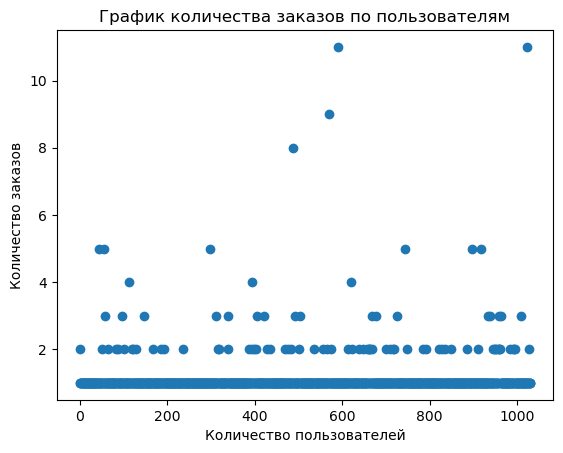

In [49]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('График количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.show()

Большинство пользователей имеют по одному заказу, а пользователей делавших более двух заказов - мало, возможно, что они  аномальные, проверим в следующем подразделе.

### 3.8 Расчет 95-го и 99-го перцентилей количества заказов на пользователя и выбор границы для определения аномальных пользователей

In [50]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Расчет 95-го и 99-го перцентелей количества заказов на пользователя показал, что не более 5% пользователей оформляли больше одного заказа, и не более 1% пользователей оформляли больше двух заказов. Будем считать количество заказов больше 2 аномальными. На основании полученных данных, разумно выбрать 2 заказа на одного пользователя, как верхнюю границу числа заказов.

### 3.9 Точечный график стоимостей заказов

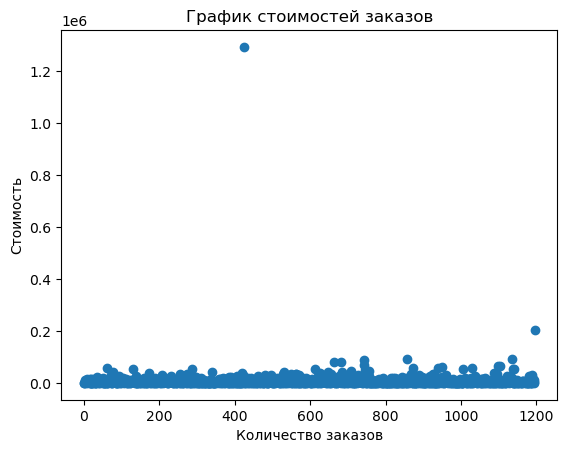

In [51]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость')
plt.show()

В таком представлении на графике видно, что стоимость большинства заказов составляет менее 200 тыс., и есть два выброса - заказы со стоимостью ~200 тыс. и ~1,3 млн. Чтобы рассмотреть детальнее, изменим масштаб:

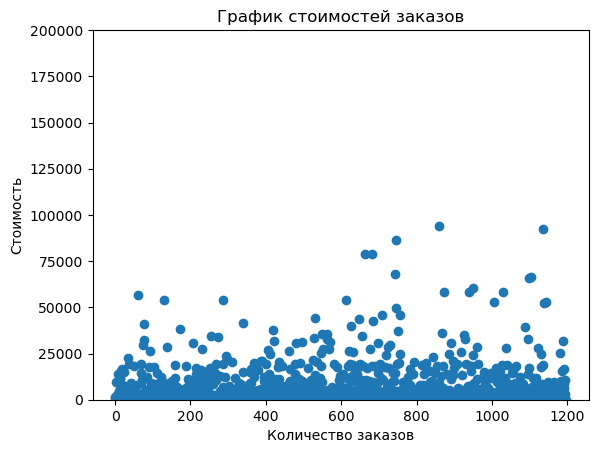

In [52]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость')
plt.ylim(0, 200000)
plt.show()

Здесь уже видно, что сумма большинства заказов составляет менее 50тыс, основная часть из которых находится в диапазоне до 25 тыс. Проверим эти предварительные выводы в следующем подразделе.

### 3.10 Расчет 95-го и 99-го перцентилей стоимости заказов и выбор границы для определения аномальных заказов

In [53]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Расчет 95-го и 99-го перцентелей стоимости заказов показал, что не более 5% пользователей оформляли заказы на сумму больше 26785, и не более 1% пользователей оформляли заказы на сумму больше 53904. Поскольку принято отсеивать от 1% до 5% наблюдений с крайними значениями, выберем сумму в 50000 как верхнюю границу суммы заказов, а значения выше 50 тыс. будем считать аномальными.

### 3.11 Расчет статистической значимости различий в среднем количестве заказов между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем количестве заказов на пользователя между группами по «сырым» данным, т.е. без удаления аномальных пользователей.
Сформулируем нулевую и альтернативную гипотезы: 
```
H_0: Различий в среднем количестве заказов между группами нет
H_1: Различия в среднем количестве заказов между группами есть
alpha = 0.05
```
Поскольку в данных есть выбросы, для проверки отличия распределений двух выборок будем применять непараметрический критерий Манна-Уитни, и установим стандартный уровень статистической значимости - равный 0.05.   

Начнем с подготовки данных:

In [54]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,718,709,718,709
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,618,580,1336,1289
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,507,1843,1796
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,712,767,2555,2563
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,753,705,3308,3268


Теперь посчитаем статистическую значимость различия в среднем количестве заказов между группами:

In [55]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders']

Объявим переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни:

In [56]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(
    0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(
    0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Теперь применим критерий и отформатируем `p-value`, округлив его до трёх знаков после запятой:

In [58]:
print('P-value =', '{0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительная разница: ', '{0:.4f}'.format(sampleB.mean() / sampleA.mean() - 1))

P-value = 0.017
Относительная разница:  0.1382


P-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет - отвергаем, а относительный выигрыш группы B равен 15.99%. Вывод: По «сырым» данным различия в среднем числе заказов между группами A и B есть.

### 3.12 Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным, т.е. без удаления аномальных пользователей.
Сформулируем нулевую и альтернативную гипотезы: 
```
H_0: Различий в среднем чеке заказа между группами нет
H_1: Различия в среднем чеке заказа между группами есть
alpha = 0.05
```
На размер среднего чека также влияют выбросы, поэтому для расчета статистической значимости различий в среднем чеке, данные о выручке с заказов в чеке также передадим критерию mannwhitneyu(), и  уровень статистической значимости оставим стандартным - 0.05:

In [59]:
print('P-value =', '{0:.3f}'.format(
    stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительная разница: ', '{0:.4f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean() - 1)) 

P-value = 0.729
Относительная разница:  0.2587


P-value значительно выше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия - нет, при этом средний чек группы B выше на 28.66%. Вывод: наблюдаемая относительная разница вероятно получена случайно, на нее могли повлиять выбросы.

### 3.13 Расчет статистической значимости различий в среднем количестве заказов между группами по «очищенным» данным

Итак, приступим к очистке данных. В качестве аномальных, мы решили рассматривать пользователей, которые оформили более 2-х заказов, а также заказы с суммой более 50 тыс. 
В переменную **usersWithManyOrders** запишем срез данных с количеством заказов более 2-х, а в переменную **usersWithExpensiveOrders** запишем срез данных с суммой заказов более 50 тыс. Затем объединим данные по аномальным пользователям в таблице **abnormalUsers**: 

In [60]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['user_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head()) # выводим первые 5 строк таблицы
print('Количество аномальных пользователей: ', abnormalUsers.shape[0]) # выводим количество аномальных пользователей

1099    148427295
18      199603092
23      237748145
37      249864742
68      457167155
dtype: int64
Количество аномальных пользователей:  37


Теперь узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по "очищенным" данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [61]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам и посмотрим, насколько изменились результаты после очистки данных:

In [62]:
print('P-value =', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительная разница: ', '{0:.4f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-value = 0.008
Относительная разница:  0.1823


P-value также меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет - также отвергаем, а относительный выигрыш группы B вырос до 19.82%. 

### 3.14 Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [63]:
print('P-value =', 
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительная разница: ', 
    "{0:.4f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value = 0.940
Относительная разница:  0.0191


P-value также значительно выше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия - также нет, а относительная разница средних чеков между группами после очистки данных снизилась до ничтожного уровня - 1,1 %  Вывод: влияние выбросов подтвердилось.

### 3.15 Решение по результатам теста

На основе анализа результатов А/В-теста, установлено следующее:
- На графиках кумулятивных метрик замечены опережающие темпы роста по выручке группы В и  относительный прирост среднего количества заказов группы B на уровне 16%  
- Отвергнута нулевая гипотеза: "Различий в среднем количестве заказов между группами нет",  как в массиве "сырых", так и в массиве "очищенных" данных. Зафиксирована относительная разница (в пользу группы В) 15.99% для "сырых" данных и 19.82% для "очищенных" данных.  
- Нет причин отвергать нулевую гипотезу: "Различий в среднем чеке заказа между группами нет", как в массиве "сырых", так и в массиве "очищенных" данных. Зафиксирована относительная разница (в пользу группы В) 28.66% для "сырых" данных и 1.1% для "очищенных" данных, влияние выбросов на средний чек подтвердилось.

Опираясь на успешные показатели различий в среднем количестве заказов и приросте выручки, рекомендуется остановить тест и зафиксировать победу группы **В**

## 4 Общий вывод

**В рамках работы над данным проектом:**

**На этапе обзора и предобработки данных:**  
1. Устранены нарушения стиля при именовании заголовков, а также несоответствие формата данных в столбцах с датой и временем.

2. Удалены данные 58 пользователей, попавших во время тестирования в обе группы.

**В разделе приоритизация гипотез:**  
1. С учетом охвата аудитории (фреймворк RICE), приоритет следует отдать гипотезе с индексом 7:  
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

2. Без учета охвата аудитории (фреймворк ICE) приоритет следует отдать гипотезе с индексом 8:  
"Запустить акцию, дающую скидку на товар в день рождения".

**В разделе Анализ А/В-теста:**
1. Выявлено статистически значимое различие в среднем количестве заказов между группами, зафиксирована относительная разница в пользу группы В на уровне 15.99% для "сырых" данных и 19.82% для "очищенных" данных.

2. Не выявлено статистически значимого различия в среднем чеке заказа между группами, зафиксирована относительная разница в пользу группы В на уровне 28.66% для "сырых" данных и 1.1% для "очищенных" данных, влияние выбросов на средний чек подтвердилось.

3. На основе успешных показатели различий в среднем количестве заказов, рекомендовано остановить тест и зафиксировать победу группы **В**.